# 1. Data Source and Contents

In [76]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import graphviz
from six import StringIO
from IPython.display import Image
import pydotplus
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, roc_auc_score, RocCurveDisplay

In [77]:
#loading in data
df = pd.read_csv("https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true")

In [78]:
# removing first letter and the period from hours_per_week_bin,	occupation_bin,	msr_bin, capital_gl_bin, race_sex_bin, education_num_bin, education_bin, workclass_bin, age_bin
df['hours_per_week_bin'] = df['hours_per_week_bin'].str[2:]
df['occupation_bin'] = df['occupation_bin'].str[2:]
df['msr_bin'] = df['msr_bin'].str[2:]
df['capital_gl_bin'] = df['capital_gl_bin'].str[2:]
df['race_sex_bin'] = df['race_sex_bin'].str[2:]
df['education_num_bin'] = df['education_num_bin'].str[2:]
df['education_bin'] = df['education_bin'].str[2:]
df['workclass_bin'] = df['workclass_bin'].str[2:]
df['age_bin'] = df['age_bin'].str[2:]

df.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,31-40,Mid - Low,Mid,> 0,High,13,Bachelors,income,36-40 & 56-60,train,0
1,0-30,High,High,= 0,High,13,Bachelors,income,40-55,train,0
2,31-40,Low,Mid,= 0,High,9-12,Mid,income,36-40 & 56-60,train,0
3,31-40,Low,High,= 0,Mid,0-8,Low,income,40-55,train,0
4,31-40,High,High,= 0,Low,13,Bachelors,income,26-30 & 71-100,train,0


# 2. Finding Optimal Value of a key Ensemble Method Hyperparameter

In [79]:
# creating train and test datasets
df_train = df[df['flag'] == 'train']
df_test = df[df['flag'] == 'test']

features_cols = ['hours_per_week_bin',	'occupation_bin',	'msr_bin', 'capital_gl_bin', 'race_sex_bin', 'education_num_bin', 'education_bin', 'workclass_bin', 'age_bin']
x_train = df_train[features_cols]
y_train = df_train['y']

x_test = df_test[features_cols]
y_test = df_test['y']

In [80]:
# encoding the dataset
x_train = pd.get_dummies(x_train, columns = features_cols, drop_first=True)
x_test = pd.get_dummies(x_test, columns = features_cols, drop_first=True)

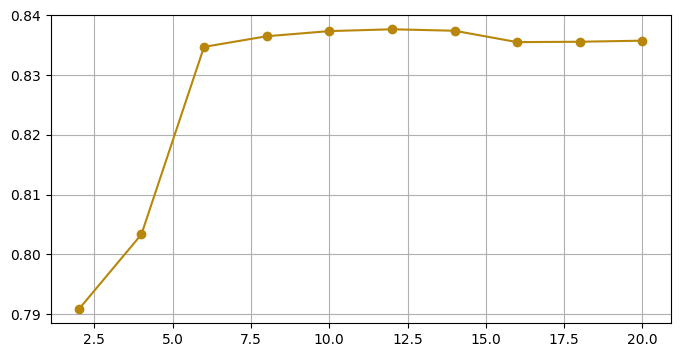

In [81]:
results = []
max_depth_options = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
for trees in max_depth_options:
    model = DecisionTreeClassifier(max_depth=trees, random_state=101)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = np.mean(y_test == y_pred)
    results.append(accuracy)

# plot 
plt.figure(figsize=(8,4))
pd.Series(results, max_depth_options).plot(color="darkgoldenrod", marker="o")
plt.grid()

# 3. Building a Random Forest Model

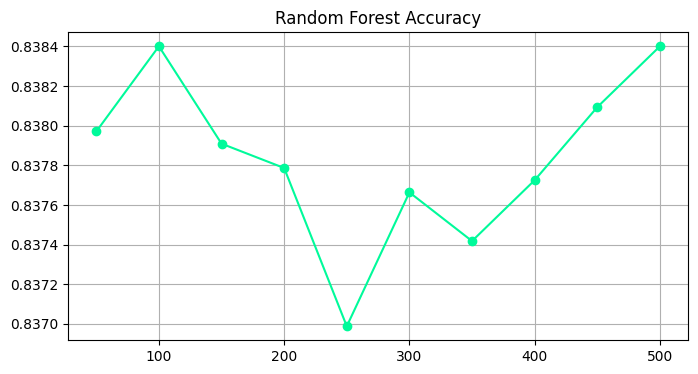

In [82]:
# finding optimal # of estimators for random forest
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

accuracy_results = []
auc_results = []

for trees in n_estimators:
    rf = RandomForestClassifier(n_estimators=trees, random_state=101)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    accuracy_results.append(accuracy)
    auc_results.append(auc)

results = ([accuracy_results, auc_results])


# plot accuracy
plt.figure(figsize=(8,4))
pd.Series(accuracy_results, n_estimators).plot(color="mediumspringgreen", marker="o")
plt.title('Random Forest Accuracy')
plt.grid()

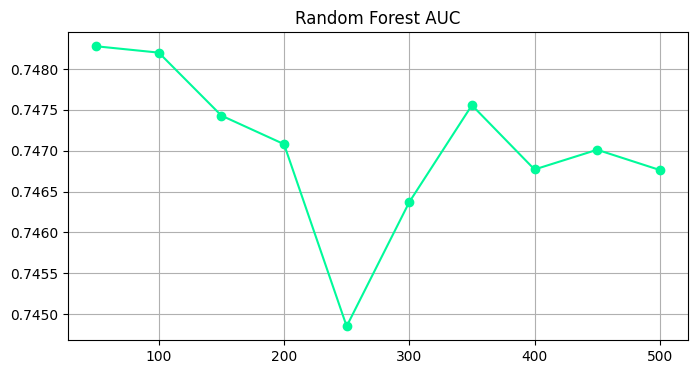

In [83]:
# plot auc
plt.figure(figsize=(8,4))
pd.Series(auc_results, n_estimators).plot(color="mediumspringgreen", marker="o")
plt.title('Random Forest AUC')
plt.grid()

In [84]:
#storing max accuracy and auc
max_rf = [max(accuracy_results), max(auc_results)]
print("Max Accuracy:", max(accuracy_results), "Max AUC:", max(auc_results))

#print results
rf_results = pd.DataFrame(results, columns = n_estimators, index = ['Accuracy', 'AUC'])
rf_results

Max Accuracy: 0.8384005896443707 Max AUC: 0.7482791326128317


,50,100,150,200,250,300,350,400,450,500
Accuracy,0.837971,0.838401,0.837909,0.837786,0.836988,0.837664,0.837418,0.837725,0.838093,0.838401
AUC,0.748279,0.748201,0.747431,0.747081,0.744852,0.746372,0.747558,0.746771,0.747013,0.746765


1. Write your observations about the Classifier’s behavior with respect to the number of estimators. <br>
The accuracy increases to 100 initially but drops sharply as it reaches 250. Then again, it rises steadily to 500 with a minor drop from at 350. As the number of models (trees) increases the diversification raises the accuracy score until a certain point is reached. <br>
2. Is there an optimal value of the estimator within the given range? <br>
There seems to be 2 optimal value points (100 and 500) that share the highest accuracy range. 

# 4. Building AdaBoost, Gradient Boost, and XGB

c:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\Kevin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is 

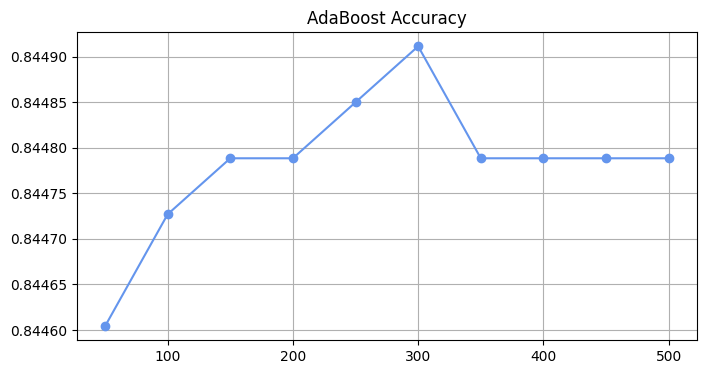

In [85]:
# finding optimal # of estimators for adaboost
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

accuracy_results = []
auc_results = []

for trees in n_estimators:
    ab = AdaBoostClassifier(n_estimators=trees, random_state=101)
    ab.fit(x_train, y_train)
    y_pred = ab.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    accuracy_results.append(accuracy)
    auc_results.append(auc)

results = ([accuracy_results, auc_results])


# plot accuracy
plt.figure(figsize=(8,4))
pd.Series(accuracy_results, n_estimators).plot(color="cornflowerblue", marker="o")
plt.title('AdaBoost Accuracy')
plt.grid()

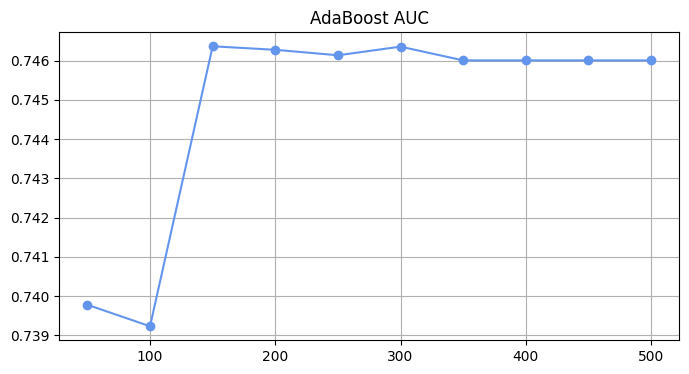

In [86]:
# plot auc
plt.figure(figsize=(8,4))
pd.Series(auc_results, n_estimators).plot(color="cornflowerblue", marker="o")
plt.title('AdaBoost AUC')
plt.grid()

In [87]:
#storing max accuracy and auc
max_ab = [max(accuracy_results), max(auc_results)]
print("Max Accuracy:", max(accuracy_results), "Max AUC:", max(auc_results))

#print results
ab_results = pd.DataFrame(results, columns = n_estimators, index = ['Accuracy', 'AUC'])
ab_results

Max Accuracy: 0.8449112462379461 Max AUC: 0.7463668172782401


,50,100,150,200,250,300,350,400,450,500
Accuracy,0.844604,0.844727,0.844788,0.844788,0.844850,0.844911,0.844788,0.844788,0.844788,0.844788
AUC,0.739781,0.739233,0.746367,0.746277,0.746138,0.746357,0.746008,0.746008,0.746008,0.746008


1. Write your observations about the Classifier’s behavior with respect to the number of estimators. <br>
The accuracy increases to 300 then drops after that. <br>
2. Is there an optimal value of the estimator within the given range? <br>
There seems to be a optimal value point of 300.

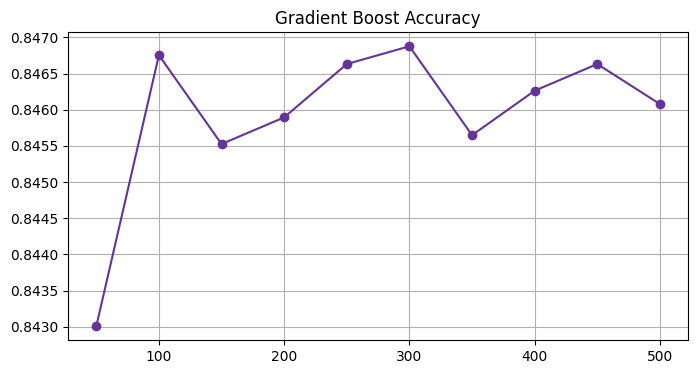

In [88]:
# finding optimal # of estimators for gradient boosting
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

accuracy_results = []
auc_results = []

for trees in n_estimators:
    gb = GradientBoostingClassifier(n_estimators=trees, random_state=101)
    gb.fit(x_train, y_train)
    y_pred = gb.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    accuracy_results.append(accuracy)
    auc_results.append(auc)

results = ([accuracy_results, auc_results])


# plot accuracy
plt.figure(figsize=(8,4))
pd.Series(accuracy_results, n_estimators).plot(color="rebeccapurple", marker="o")
plt.title('Gradient Boost Accuracy')
plt.grid()

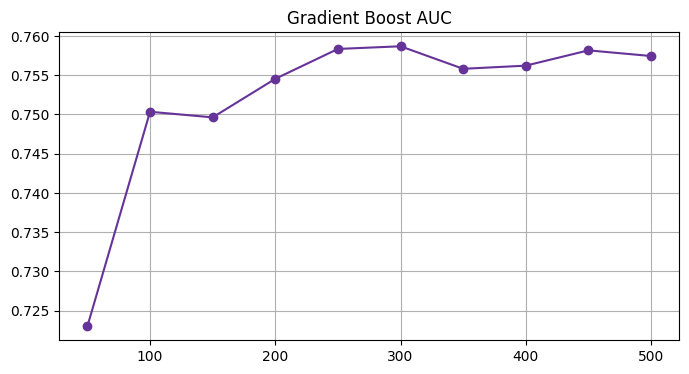

In [89]:
# plot auc
plt.figure(figsize=(8,4))
pd.Series(auc_results, n_estimators).plot(color="rebeccapurple", marker="o")
plt.title('Gradient Boost AUC')
plt.grid()

In [90]:
#storing max accuracy and auc
max_gb = [max(accuracy_results), max(auc_results)]
print("Max Accuracy:", max(accuracy_results), "Max AUC:", max(auc_results))

#print results
gb_results = pd.DataFrame(results, columns = n_estimators, index = ['Accuracy', 'AUC'])
gb_results

Max Accuracy: 0.8468767274737424 Max AUC: 0.7586890520252897


,50,100,150,200,250,300,350,400,450,500
Accuracy,0.843007,0.846754,0.845525,0.845894,0.846631,0.846877,0.845648,0.846263,0.846631,0.846078
AUC,0.723021,0.750347,0.749633,0.754544,0.758349,0.758689,0.755820,0.756222,0.758169,0.757448


1. Write your observations about the Classifier’s behavior with respect to the number of estimators. <br>
The accuracy increases to 100 initially but drops at 150. It then rises again to 300 and drops at 350 and then a gentle rise to 450, falling at 500. <br>
2. Is there an optimal value of the estimator within the given range? <br>
There seems to be an optimal point of 300.

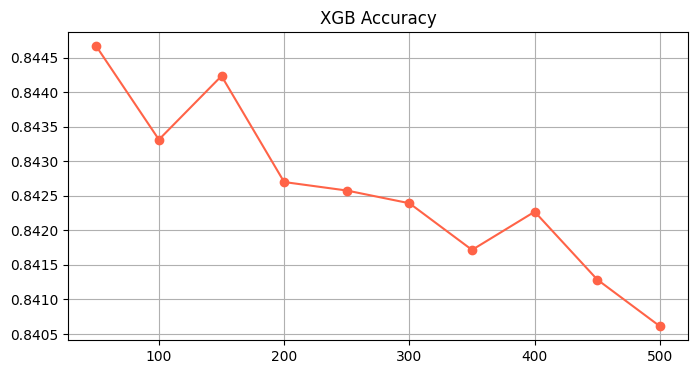

In [91]:
# finding optimal # of estimators for XGB
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

accuracy_results = []
auc_results = []

for trees in n_estimators:
    xgb = XGBClassifier(n_estimators=trees, random_state=101)
    xgb.fit(x_train, y_train)
    y_pred = xgb.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    accuracy_results.append(accuracy)
    auc_results.append(auc)

results = ([accuracy_results, auc_results])


# plot accuracy
plt.figure(figsize=(8,4))
pd.Series(accuracy_results, n_estimators).plot(color="tomato", marker="o")
plt.title('XGB Accuracy')
plt.grid()

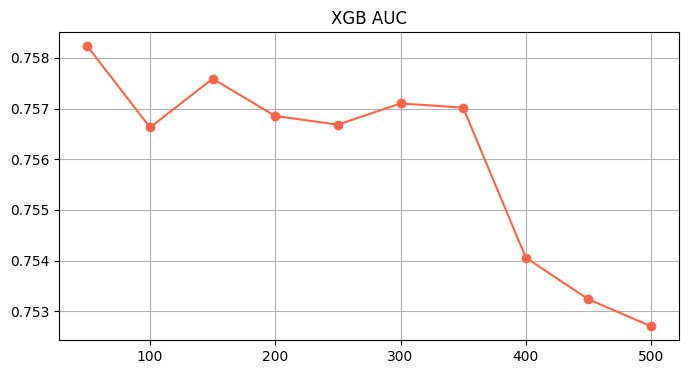

In [92]:
# plot auc
plt.figure(figsize=(8,4))
pd.Series(auc_results, n_estimators).plot(color="tomato", marker="o")
plt.title('XGB AUC')
plt.grid()

In [93]:
#storing max accuracy and auc
max_xgb = [max(accuracy_results), max(auc_results)]
print("Max Accuracy:", max(accuracy_results), "Max AUC:", max(auc_results))

#print results
xgb_results = pd.DataFrame(results, columns = n_estimators, index = ['Accuracy', 'AUC'])
xgb_results

Max Accuracy: 0.8446655610834716 Max AUC: 0.758229282126653


,50,100,150,200,250,300,350,400,450,500
Accuracy,0.844666,0.843314,0.844236,0.842700,0.842577,0.842393,0.841717,0.842270,0.841287,0.840612
AUC,0.758229,0.756626,0.757589,0.756853,0.756683,0.757101,0.757018,0.754057,0.753234,0.752702


1. Write your observations about the Classifier’s behavior with respect to the number of estimators. <br>
The accuracy starts off highest at 50 and declines all the way down. <br>
2. Is there an optimal value of the estimator within the given range? <br>
There seems to be an optimal point at 50.

# 5. Compare Performance

In [100]:
max_scores = pd.DataFrame([max_rf, max_ab, max_gb, max_xgb], columns = ['Accuracy', 'AUC'], index = ['Random Forest', 'AdaBoost', 'Gradient Boost', 'XGB'])
max_scores

,Accuracy,AUC
Random Forest,0.838401,0.748279
AdaBoost,0.844911,0.746367
Gradient Boost,0.846877,0.758689
XGB,0.844666,0.758229
